In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori

import warnings
warnings.filterwarnings('ignore')

In [48]:
df_member = pd.read_csv('data member.csv')

df_trans_cleaned = pd.read_csv('transaction_cleaned.csv')

trans_2021 = pd.read_csv('transaction 2021.csv')
trans_2022 = pd.read_csv('transaction 2022.csv')
trans_2023 = pd.read_csv('transaction 2023.csv')
df_trans = pd.concat([trans_2021, trans_2022, trans_2023])

In [4]:
df_member.tail(3)

,ent,original_status,join_month,join_year,sponsor
590562,H3CCCEC7,A,7,2010,H3CCC4JP
590563,H3CCCE4I,A,7,2010,H3CCC4JP
590564,H3CCCEEF,A,7,2010,H3CCC4WU


In [5]:
df_member.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590565 entries, 0 to 590564
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ent              590565 non-null  object
 1   original_status  590565 non-null  object
 2   join_month       590565 non-null  int64 
 3   join_year        590565 non-null  int64 
 4   sponsor          590565 non-null  object
dtypes: int64(2), object(3)
memory usage: 22.5+ MB


In [6]:
df_trans_cleaned.tail(3)

,payment_date,ent,center,total_amount,discount,paid_amount,trans_origin_type,product,qty
4129111,2023-07-06 00:00:00.000,TCCEQ4Z4R4Y,TKC1Z4,2500.0,NaN,2500,offline,KCQCEJ,1
4129112,2023-07-06 00:00:00.000,TCCEQEZJQ4F,TKC1Z4,2500.0,NaN,2500,offline,KCQCER,1
4129113,2023-07-06 00:00:00.000,TCCEQ434R1F,TKC1Z4,2500.0,NaN,2500,offline,KCQCER,1


In [7]:
df_trans_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4129114 entries, 0 to 4129113
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   payment_date       object 
 1   ent                object 
 2   center             object 
 3   total_amount       float64
 4   discount           float64
 5   paid_amount        int64  
 6   trans_origin_type  object 
 7   product            object 
 8   qty                int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 283.5+ MB


In [8]:
df_trans.tail(3)

,payment_date,ent,center,product_json,total_amount,discount,paid_amount,trans_origin_type
362106,2023-07-06 00:00:00.000,TCCEQ4Z4R4Y,TKC1Z4,"[{""product"":""KCQCEJ"",""qty"":1}]",2500.0,NaN,2500,offline
362107,2023-07-06 00:00:00.000,TCCEQEZJQ4F,TKC1Z4,"[{""product"":""KCQCER"",""qty"":1}]",2500.0,NaN,2500,offline
362108,2023-07-06 00:00:00.000,TCCEQ434R1F,TKC1Z4,"[{""product"":""KCQCER"",""qty"":1}]",2500.0,NaN,2500,offline


In [9]:
# df_trans.groupby()

In [10]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2406316 entries, 0 to 362108
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   payment_date       object 
 1   ent                object 
 2   center             object 
 3   product_json       object 
 4   total_amount       float64
 5   discount           float64
 6   paid_amount        int64  
 7   trans_origin_type  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 165.2+ MB


### Data Prep

In [64]:
# clean data type
df_trans_cleaned['payment_date'] = pd.to_datetime(df_trans_cleaned['payment_date'])
df_trans_cleaned['payment_ym'] = df_trans_cleaned['payment_date'].dt.to_period('M')

df_trans_cleaned['trans_id'] = df_trans_cleaned['trans_id'].astype(str)

df_trans['payment_date'] = pd.to_datetime(df_trans['payment_date'])
df_trans['payment_ym'] = df_trans['payment_date'].dt.to_period('M')

df_member['join_ym'] = pd.to_datetime(df_member['join_year'].astype(str) + '-' + df_member['join_month'].astype(str))

In [12]:
# create feature df
df_clus = df_member[['ent']]

In [13]:
maxmonth = df_trans['payment_ym'].max()

df_trans_last3m = df_trans.loc[df_trans['payment_ym'] > (maxmonth - 3), :]
df_trans_last6m = df_trans.loc[df_trans['payment_ym'] > (maxmonth - 6), :]

df_trans_cleaned_last3m = df_trans_cleaned.loc[df_trans_cleaned['payment_ym'] > (maxmonth - 3), :]
df_trans_cleaned_last6m = df_trans_cleaned.loc[df_trans_cleaned['payment_ym'] > (maxmonth - 6), :]

In [14]:
maxdate = df_trans['payment_date'].max()
df_clus['mem_duration'] = ((maxdate - df_member['join_ym'])/np.timedelta64(1, 'M')).astype('int')

In [15]:
f0 = df_trans.groupby('ent').agg({'total_amount': ['sum',  
                                                   'count']}
                                ).reset_index()
f0.columns = ['ent', 'sale', 'num_trans']
f0['avg_ticketsize'] = f0['sale']/f0['num_trans']

f1 = df_trans_last3m.groupby('ent').agg({'total_amount': ['sum',
                                                          'count']}
                                       ).reset_index()
f1.columns = ['ent', 'sale_last3m', 'num_trans_last3m']
f1['avg_ticketsize_last3m'] = f1['sale_last3m']/f1['num_trans_last3m']

f2 = df_trans_last6m.groupby('ent').agg({'total_amount': ['sum',
                                                          'count']}
                                       ).reset_index()
f2.columns = ['ent', 'sale_last6m', 'num_trans_last6m']
f2['avg_ticketsize_last6m'] = f2['sale_last6m']/f2['num_trans_last6m']

f3 = df_trans.loc[df_trans['trans_origin_type']=='offline',:].groupby('ent').agg({'total_amount': 'sum'}
                                                                                 ).reset_index()
f3.columns = ['ent', 'offline_sale']

f4 = df_trans_last3m.loc[df_trans_last3m['trans_origin_type']=='offline',:].groupby('ent').agg({'total_amount': 'sum'}
                                                                                              ).reset_index()
f4.columns = ['ent', 'offline_sale_last3m']

f5 = df_trans_last6m.loc[df_trans_last6m['trans_origin_type']=='offline',:].groupby('ent').agg({'total_amount': 'sum'}
                                                                               ).reset_index()
f5.columns = ['ent', 'offline_sale_last6m']

f6 = df_trans.loc[df_trans['trans_origin_type']=='online',:].groupby('ent').agg({'total_amount': 'sum'}
                                                                               ).reset_index()
f6.columns = ['ent', 'online_sale']

f7 = df_trans_last3m.loc[df_trans_last3m['trans_origin_type']=='online',:].groupby('ent').agg({'total_amount': 'sum'}
                                                                                             ).reset_index()
f7.columns = ['ent', 'online_sale_last3m']

f8 = df_trans_last6m.loc[df_trans_last6m['trans_origin_type']=='online',:].groupby('ent').agg({'total_amount': 'sum'}
                                                                                             ).reset_index()
f8.columns = ['ent', 'online_sale_last6m']

f9 = df_member.groupby('sponsor').agg({'ent':'nunique'}).reset_index()
f9.columns = ['ent', 'num_downline']

f10 = df_member.loc[df_member['join_ym'] > df_member['join_ym'].max()-pd.DateOffset(months=3), :].groupby('sponsor').agg({'ent':'nunique'}).reset_index()
f10.columns = ['ent', 'num_downline_last3m']

f11 = df_member.loc[df_member['join_ym'] > df_member['join_ym'].max()-pd.DateOffset(months=6), :].groupby('sponsor').agg({'ent':'nunique'}).reset_index()
f11.columns = ['ent', 'num_downline_last6m']

unique_prod = df_trans_cleaned['product'].nunique()

f12 = df_trans_cleaned.groupby('ent').agg({'product': 'nunique'}).reset_index()
f12.columns = ['ent', '%pd_variety']
f12['%pd_variety'] = f12['%pd_variety']/unique_prod

f13 = df_trans_cleaned_last3m.groupby('ent').agg({'product': 'nunique'}).reset_index()
f13.columns = ['ent', '%pd_variety_last3m']
f13['%pd_variety_last3m'] = f13['%pd_variety_last3m']/unique_prod

f14 = df_trans_cleaned_last6m.groupby('ent').agg({'product': 'nunique'}).reset_index()
f14.columns = ['ent', '%pd_variety_last6m']
f14['%pd_variety_last6m'] = f14['%pd_variety_last6m']/unique_prod

In [16]:
feature = [f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14]
for i in feature:
    df_clus = df_clus.merge(i, on='ent', how='outer')

df_clus.tail(3)

,ent,mem_duration,sale,num_trans,avg_ticketsize,sale_last3m,num_trans_last3m,avg_ticketsize_last3m,sale_last6m,num_trans_last6m,...,offline_sale_last6m,online_sale,online_sale_last3m,online_sale_last6m,num_downline,num_downline_last3m,num_downline_last6m,%pd_variety,%pd_variety_last3m,%pd_variety_last6m
796543,TZZZEZCP,NaN,1962000.0,7.0,280285.714286,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014235,NaN,NaN
796544,TZZZJZ4Y,NaN,1283000.0,2.0,641500.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005338,NaN,NaN
796545,TZZZW417,NaN,50000.0,1.0,50000.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001779,NaN,NaN


In [17]:
df_clus = df_clus.dropna(subset='mem_duration')
df_clus = df_clus.fillna(0)

### Clustering

In [19]:
# # remove outliner
# def remove_outliner(df, column_name):
#     q_low = df[column_name].quantile(0.0003) # mean-3sd
#     q_hi  = df[column_name].quantile(0.9997) # mean+3sd
#     df_filtered = df[(df[column_name] <= q_hi) & (df[column_name] >= q_low)]
#     return df_filtered

# for c in df_clus.columns[1:]:
#     df_clus =  remove_outliner(df_clus, c)

In [20]:
df_clus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590565 entries, 0 to 590564
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ent                    590565 non-null  object 
 1   mem_duration           590565 non-null  float64
 2   sale                   590565 non-null  float64
 3   num_trans              590565 non-null  float64
 4   avg_ticketsize         590565 non-null  float64
 5   sale_last3m            590565 non-null  float64
 6   num_trans_last3m       590565 non-null  float64
 7   avg_ticketsize_last3m  590565 non-null  float64
 8   sale_last6m            590565 non-null  float64
 9   num_trans_last6m       590565 non-null  float64
 10  avg_ticketsize_last6m  590565 non-null  float64
 11  offline_sale           590565 non-null  float64
 12  offline_sale_last3m    590565 non-null  float64
 13  offline_sale_last6m    590565 non-null  float64
 14  online_sale            590565 non-nu

In [21]:
X = df_clus.drop('ent', axis=1)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
# kmeans = KMeans(n_clusters=2)
# labels = kmeans.fit_predict(X)

# # Calculate silhouette score
# silhouette_avg = silhouette_score(X, labels)
# print("The average silhouette score is:", silhouette_avg)

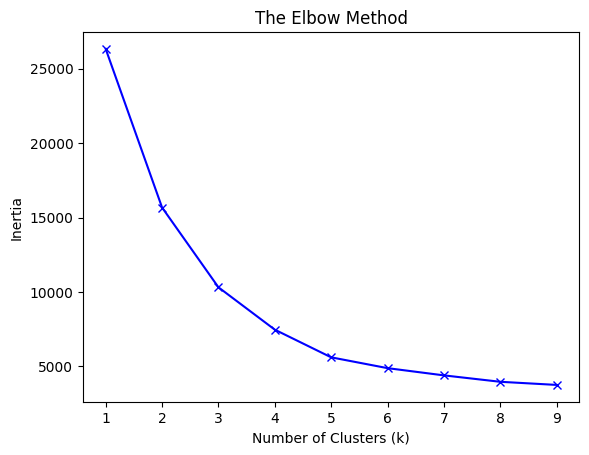

In [42]:
# Perform K-means clustering for different values of k
k_values = range(1, 10)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values against the number of clusters
plt.plot(k_values, inertia_values, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

### K-mean

In [24]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)

# Get cluster labels and cluster centers
labels_kmean = kmeans.labels_
centers_kmean = kmeans.cluster_centers_

# # Add cluster labels to the DataFrame
# df_clus['Cluster'] = labels
# df_clus.head(3)

In [25]:
# # Create a Random Forest classifier
# clf = RandomForestClassifier()

# # Train the classifier on your data
# clf.fit(X, labels)

# # Get the feature importance scores
# importance_scores = clf.feature_importances_

# # Sort the features based on importance in descending order
# sorted_indices = np.argsort(importance_scores)[::-1]

# # Print the feature rankings
# for i, idx in enumerate(sorted_indices):
#     print(f"Rank {i+1}: Feature {df_clus.columns[idx+1]}, Importance score: {importance_scores[idx]}")

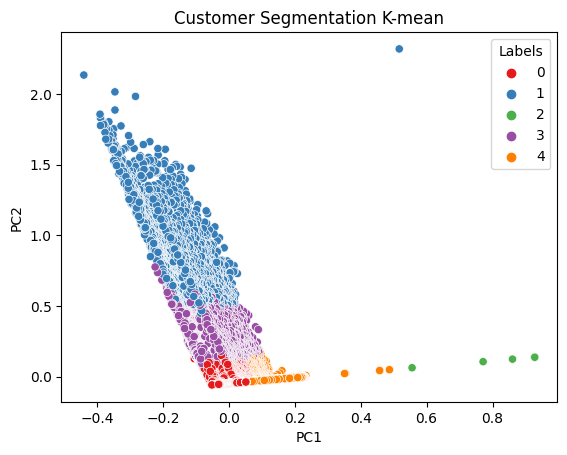

In [26]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_kmean, palette='Set1')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Segmentation K-mean')
plt.legend(title='Labels')

plt.show()

In [27]:
# df_clus['Cluster'].value_counts()

### K-median

In [28]:
from sklearn.metrics import pairwise_distances

def k_median_clustering(X, k, max_iters=500):
    # Initialize the centroids randomly
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]

    for _ in range(max_iters):
        # Compute the distances between each point and each centroid
        distances = pairwise_distances(X, centroids, metric='manhattan')

        # Assign each point to the nearest centroid
        labels = np.argmin(distances, axis=1)

        # Update the centroids by computing the median of each cluster
        new_centroids = np.array([np.median(X[labels == i], axis=0) for i in range(k)])

        # Check if the centroids have converged
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return labels, centroids


# Run k-median clustering
k = 5
labels_kmedian, centroids_kmedian = k_median_clustering(X, k)

df_clus['Cluster'] = labels_kmedian
df_clus.head(3)

,ent,mem_duration,sale,num_trans,avg_ticketsize,sale_last3m,num_trans_last3m,avg_ticketsize_last3m,sale_last6m,num_trans_last6m,...,online_sale,online_sale_last3m,online_sale_last6m,num_downline,num_downline_last3m,num_downline_last6m,%pd_variety,%pd_variety_last3m,%pd_variety_last6m,Cluster
0,UCC4CC4F,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2
1,UCC4CCEK,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,UCC4CC15,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2


In [29]:
# df_clus.to_csv('clust_perf.csv', index = False)

In [30]:
# Create a Random Forest classifier
clf = RandomForestClassifier()

# Train the classifier on your data
clf.fit(X, labels_kmedian)

# Get the feature importance scores
importance_scores = clf.feature_importances_

# Sort the features based on importance in descending order
sorted_indices = np.argsort(importance_scores)[::-1]

# Print the feature rankings
for i, idx in enumerate(sorted_indices):
    print(f"Rank {i+1}: Feature {df_clus.columns[idx+1]}, Importance score: {importance_scores[idx]}")

Rank 1: Feature mem_duration, Importance score: 0.26205958079392133
Rank 2: Feature sale, Importance score: 0.16970540061726455
Rank 3: Feature num_trans, Importance score: 0.1282973151320671
Rank 4: Feature %pd_variety, Importance score: 0.12086836518503188
Rank 5: Feature avg_ticketsize, Importance score: 0.1021603482875705
Rank 6: Feature online_sale, Importance score: 0.04509844386476467
Rank 7: Feature sale_last3m, Importance score: 0.03268875904420599
Rank 8: Feature offline_sale, Importance score: 0.02930712411663943
Rank 9: Feature %pd_variety_last3m, Importance score: 0.024326936089480545
Rank 10: Feature avg_ticketsize_last3m, Importance score: 0.019862955299597643
Rank 11: Feature num_trans_last3m, Importance score: 0.01387900799654186
Rank 12: Feature sale_last6m, Importance score: 0.010619371976647274
Rank 13: Feature %pd_variety_last6m, Importance score: 0.00990835962910281
Rank 14: Feature num_downline, Importance score: 0.007257102411477638
Rank 15: Feature online_sale_

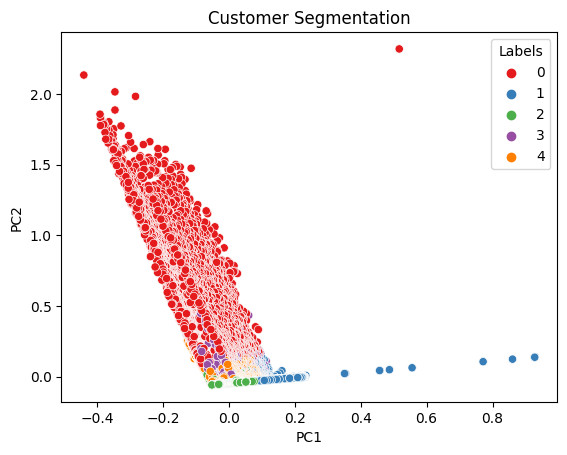

In [31]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_kmedian, palette='Set1')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Segmentation')
plt.legend(title='Labels')

plt.show()

In [32]:
df_clus['Cluster'].value_counts()

4    280285
2    151325
1     86156
3     38070
0     34729
Name: Cluster, dtype: int64

In [33]:
df_clus['Cluster'] = df_clus['Cluster'].astype(str)

In [34]:
df_clus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590565 entries, 0 to 590564
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ent                    590565 non-null  object 
 1   mem_duration           590565 non-null  float64
 2   sale                   590565 non-null  float64
 3   num_trans              590565 non-null  float64
 4   avg_ticketsize         590565 non-null  float64
 5   sale_last3m            590565 non-null  float64
 6   num_trans_last3m       590565 non-null  float64
 7   avg_ticketsize_last3m  590565 non-null  float64
 8   sale_last6m            590565 non-null  float64
 9   num_trans_last6m       590565 non-null  float64
 10  avg_ticketsize_last6m  590565 non-null  float64
 11  offline_sale           590565 non-null  float64
 12  offline_sale_last3m    590565 non-null  float64
 13  offline_sale_last6m    590565 non-null  float64
 14  online_sale            590565 non-nu

mem_duration
The ANOVA p-value is: F_onewayResult(statistic=162461.16574029537, pvalue=0.0)


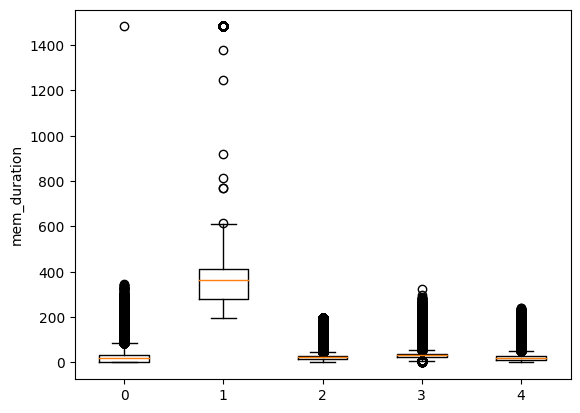

sale
The ANOVA p-value is: F_onewayResult(statistic=102503.93057196213, pvalue=0.0)


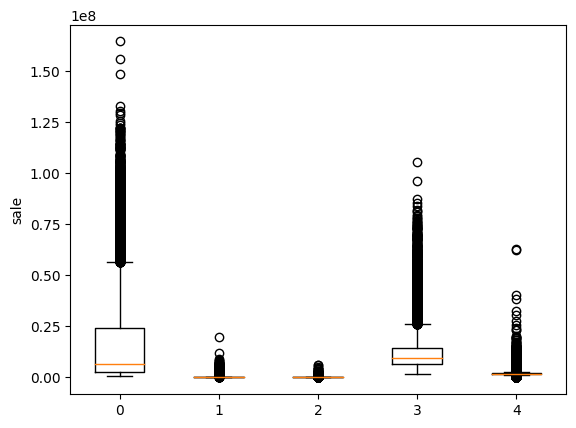

num_trans
The ANOVA p-value is: F_onewayResult(statistic=79795.86200909092, pvalue=0.0)


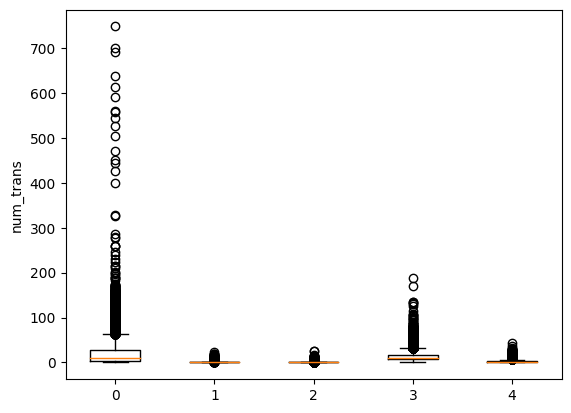

avg_ticketsize
The ANOVA p-value is: F_onewayResult(statistic=213008.71731111436, pvalue=0.0)


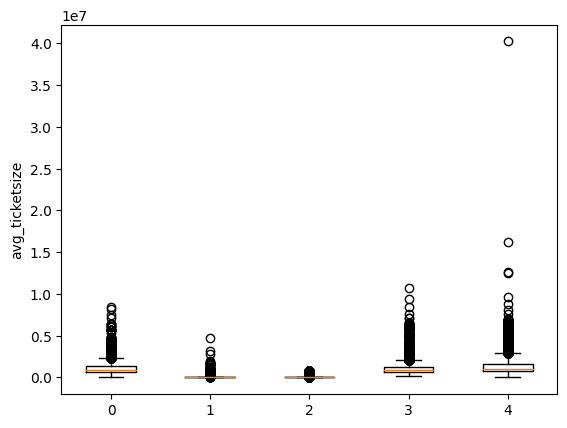

sale_last3m
The ANOVA p-value is: F_onewayResult(statistic=271768.92226314655, pvalue=0.0)


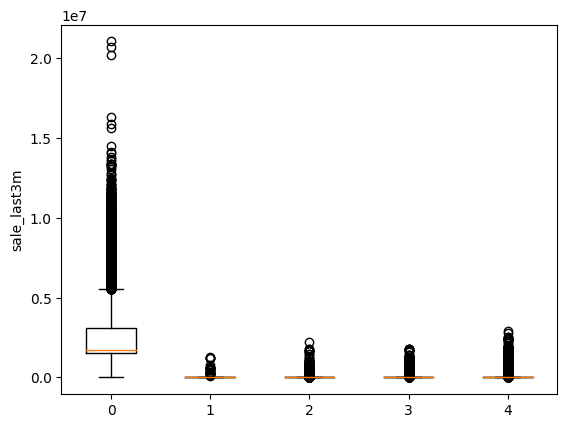

num_trans_last3m
The ANOVA p-value is: F_onewayResult(statistic=107092.83556190183, pvalue=0.0)


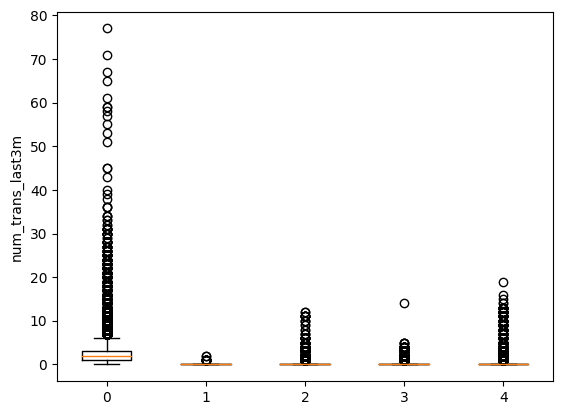

avg_ticketsize_last3m
The ANOVA p-value is: F_onewayResult(statistic=273994.371904896, pvalue=0.0)


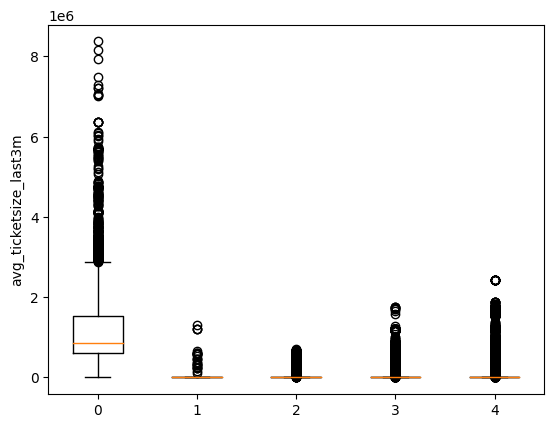

sale_last6m
The ANOVA p-value is: F_onewayResult(statistic=148110.3468832536, pvalue=0.0)


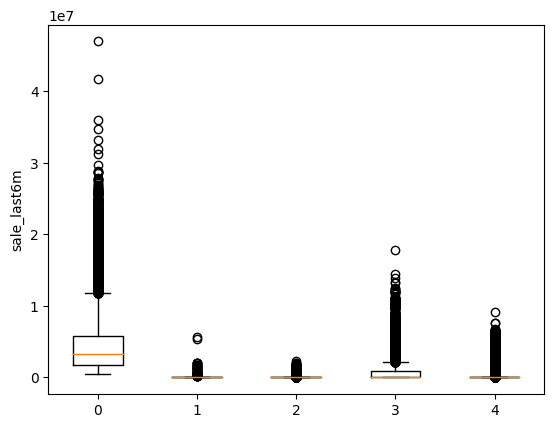

num_trans_last6m
The ANOVA p-value is: F_onewayResult(statistic=89169.78857143538, pvalue=0.0)


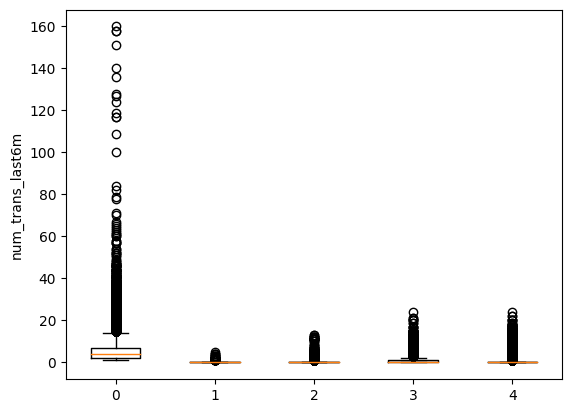

avg_ticketsize_last6m
The ANOVA p-value is: F_onewayResult(statistic=78647.46779694656, pvalue=0.0)


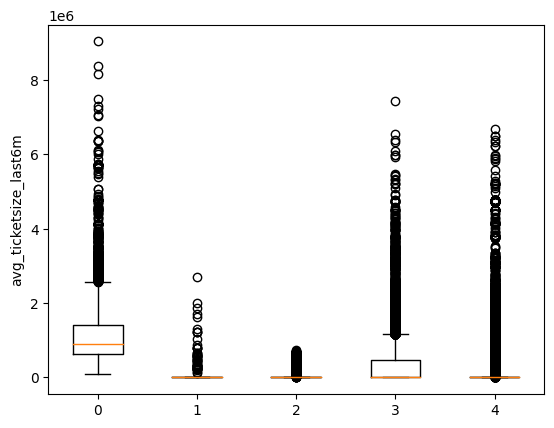

offline_sale
The ANOVA p-value is: F_onewayResult(statistic=43979.41124610231, pvalue=0.0)


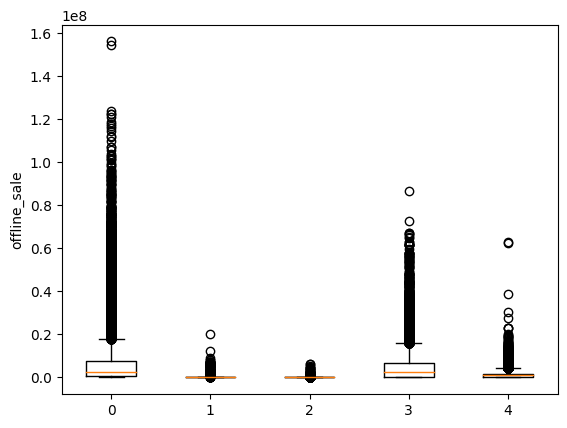

offline_sale_last3m
The ANOVA p-value is: F_onewayResult(statistic=81260.05896720107, pvalue=0.0)


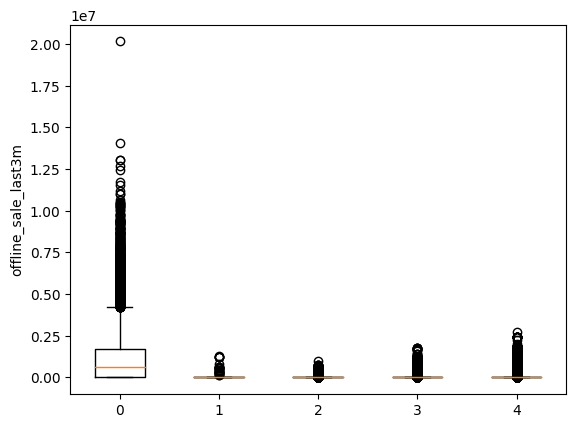

offline_sale_last6m
The ANOVA p-value is: F_onewayResult(statistic=62033.71878587627, pvalue=0.0)


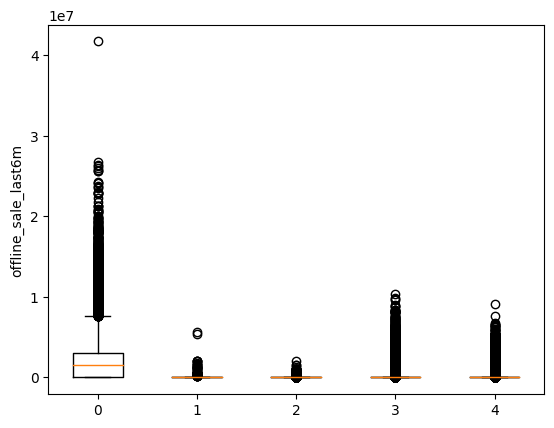

online_sale
The ANOVA p-value is: F_onewayResult(statistic=74540.95721799864, pvalue=0.0)


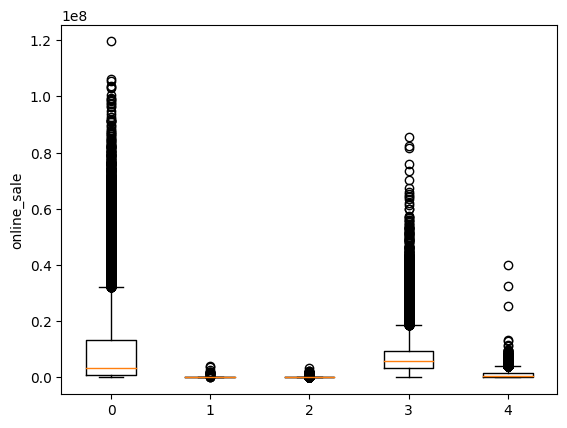

online_sale_last3m
The ANOVA p-value is: F_onewayResult(statistic=108590.61054269687, pvalue=0.0)


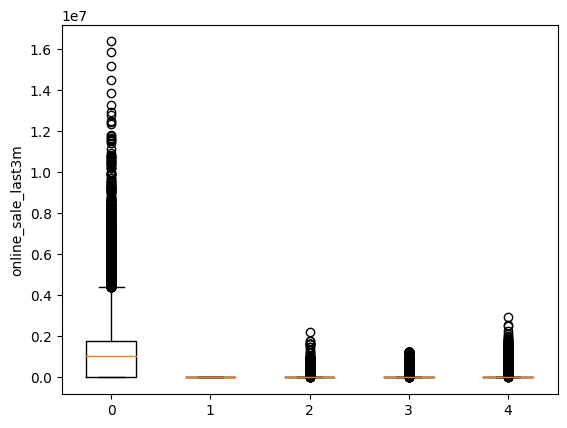

online_sale_last6m
The ANOVA p-value is: F_onewayResult(statistic=83285.41408063826, pvalue=0.0)


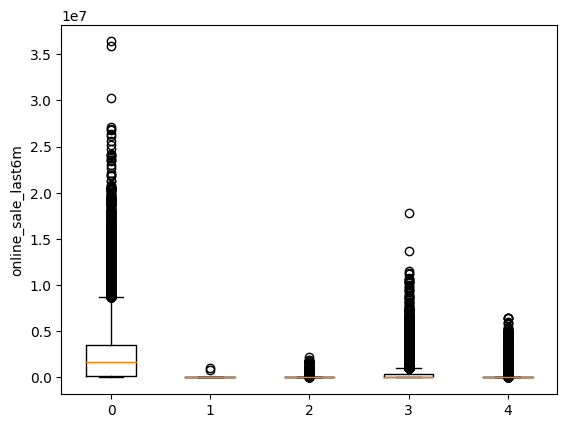

num_downline
The ANOVA p-value is: F_onewayResult(statistic=9369.973842797546, pvalue=0.0)


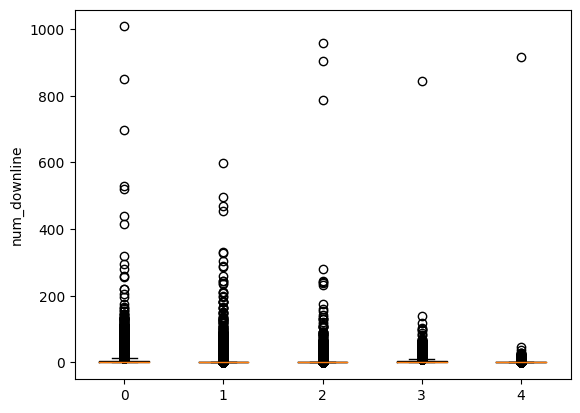

num_downline_last3m
The ANOVA p-value is: F_onewayResult(statistic=1089.9105789401162, pvalue=0.0)


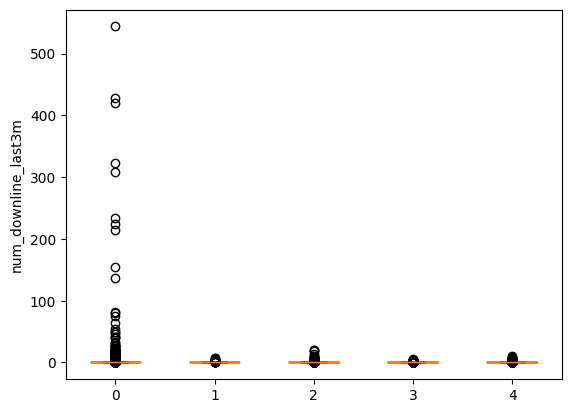

num_downline_last6m
The ANOVA p-value is: F_onewayResult(statistic=1707.358923455889, pvalue=0.0)


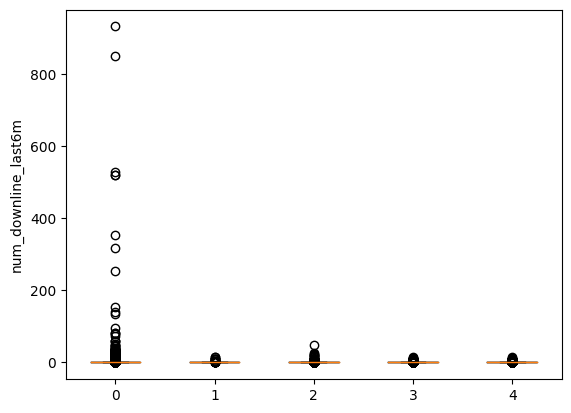

%pd_variety
The ANOVA p-value is: F_onewayResult(statistic=163267.9306322258, pvalue=0.0)


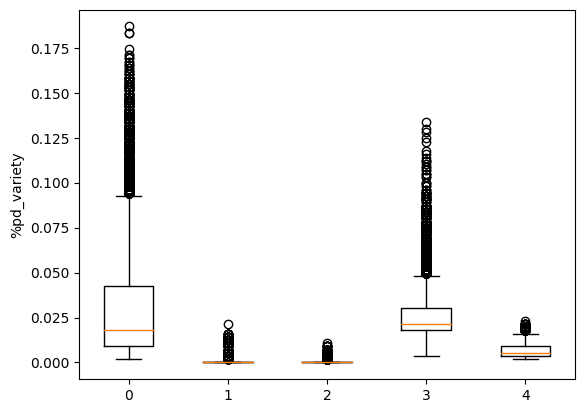

%pd_variety_last3m
The ANOVA p-value is: F_onewayResult(statistic=306732.29353327316, pvalue=0.0)


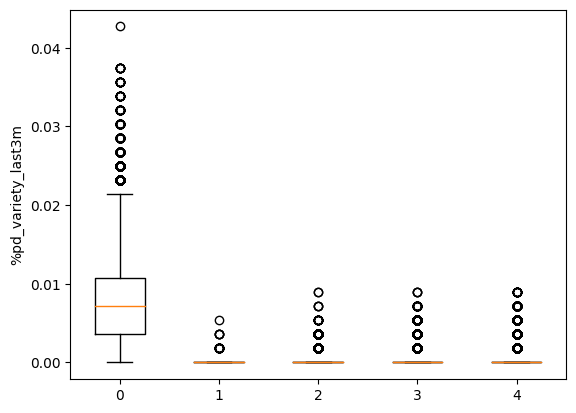

%pd_variety_last6m
The ANOVA p-value is: F_onewayResult(statistic=171231.2457968428, pvalue=0.0)


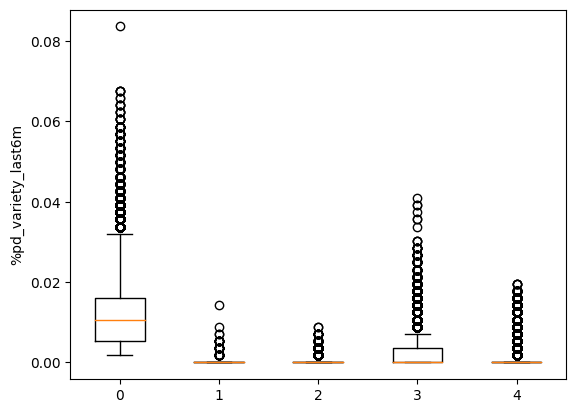

In [35]:
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

num_var = df_clus.select_dtypes(include=['float64', 'int64']).columns.to_list()

for i in num_var:
    fig, ax = plt.subplots()
    ax.boxplot([df_clus[df_clus['Cluster'] == '0'][i],
                df_clus[df_clus['Cluster'] == '1'][i],
                df_clus[df_clus['Cluster'] == '2'][i],
                df_clus[df_clus['Cluster'] == '3'][i],
                df_clus[df_clus['Cluster'] == '4'][i]
                ])
    ax.set_xticklabels(['0', '1','2','3','4'])
    ax.set_ylabel(i)

    p_value = f_oneway(df_clus[df_clus['Cluster'] == '0'][i],
                      df_clus[df_clus['Cluster'] == '1'][i],
                      df_clus[df_clus['Cluster'] == '2'][i],
                      df_clus[df_clus['Cluster'] == '3'][i],
                      df_clus[df_clus['Cluster'] == '4'][i]
                      )

    print(i)
    print("The ANOVA p-value is:", p_value)
    plt.show()

In [36]:
# import shap
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier()
# model.fit(X, labels_kmedian)

# # Create an explainer object
# explainer = shap.Explainer(model, X)

# # Calculate SHAP values
# shap_values = explainer(X)

# # Plot the SHAP summary plot
# shap.summary_plot(shap_values, X)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels_kmedian, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      6960
           1       1.00      1.00      1.00     17230
           2       1.00      1.00      1.00     30379
           3       0.99      0.99      0.99      7752
           4       1.00      1.00      1.00     55792

    accuracy                           1.00    118113
   macro avg       0.99      0.99      0.99    118113
weighted avg       1.00      1.00      1.00    118113



### product recommend

In [50]:
df_trans_cleaned.head(3)

,payment_date,ent,center,total_amount,discount,paid_amount,trans_origin_type,trans_id,product,qty
0,2021-01-01 00:00:00.000,TCC43RQQZ3B,TKC4CJ,1627000.0,0.0,0,online,1,1ECZ,1
1,2021-01-01 00:00:00.000,TCC43RQQZ3B,TKC4CJ,1627000.0,0.0,0,online,1,8CEC4Q,1
2,2021-01-01 00:00:00.000,TCC4Q4JZ4Q0,TKCEWQ,594000.0,0.0,0,online,2,4E4W,2


In [66]:
df_full = df_trans_cleaned.merge(df_clus[['ent', 'Cluster']], on='ent', how='left')

In [67]:
df_cluster_0 = df_full[df_full['Cluster'] == '0']
df_cluster_1 = df_full[df_full['Cluster'] == '1']
df_cluster_2 = df_full[df_full['Cluster'] == '2']
df_cluster_3 = df_full[df_full['Cluster'] == '3']
df_cluster_4 = df_full[df_full['Cluster'] == '4']

In [71]:
# import os

# df_list = [df_cluster_0, df_cluster_1, df_cluster_2, df_cluster_3, df_cluster_4]

# for i, df in enumerate(df_list):
#     df_prep = df.sort_values(by='payment_date')
#     df_prep = df_prep[['ent', 'trans_id']].drop_duplicates()
#     df_group = df_prep.groupby(['ent'])['trans_id'].apply('|'.join).reset_index()

#     df_trans = df_group['trans_id'].str.get_dummies('|').astype(pd.SparseDtype('bool'))
#     print(f"df_trans_{i} shape:", df_trans.shape)

#     frequent_itemsets = apriori(df_trans, min_support=0.05, use_colnames=True)
#     frequent_itemsets.sort_values('support', ascending=False, inplace=True)

#     asso_rule = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
#     asso_rule.sort_values('confidence', ascending=False, inplace=True)

#     print(f"Association rules for df_cluster_{i}:")
#     display(asso_rule)

#     # filename = f"asso_rule_df_cluster_{i}.csv"
#     # asso_rule.to_csv(filename, index=False)
#     # print(f"Association rules for df_cluster_{i} saved to {os.getcwd()}/{filename}")